In [1]:
import xtrack as xt
import xpart as xp
import xplot as xplt
import numpy as np

In [2]:
## Generate a simple line
n = 6
fodo = [
    xt.Multipole(length=0.2, knl=[0, +0.2], ksl=[0, 0]),
    xt.Drift(length=1.0),
    xt.Multipole(length=0.2, knl=[0, -0.2], ksl=[0, 0]),
    xt.Drift(length=1.0),
    xt.Multipole(length=1.0, knl=[2 * np.pi / n], hxl=[2 * np.pi / n]),
    xt.Drift(length=1.0),
]
line = xt.Line(elements=n * fodo)

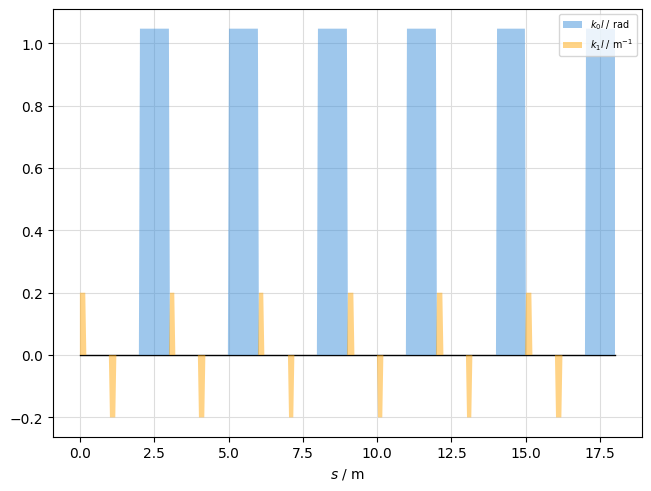

In [3]:
plot = xplt.KnlPlot(line)

In [ ]:
## Twiss
tracker = xt.Tracker(line=line)
tw = tracker.twiss(
    method="4d",
    particle_ref=xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, p0c=1e9),
    at_s=np.linspace(0, line.get_length(), 500),
)

generating ./9ae1dd517df04d8aac775a068d97b3bb.c
the current directory is '/mnt/d/pniederm/Hessenbox/GSI/Particle-Tracking/xplot/examples'
running build_ext
building '9ae1dd517df04d8aac775a068d97b3bb' extension
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.8 -c 9ae1dd517df04d8aac775a068d97b3bb.c -o ./9ae1dd517df04d8aac775a068d97b3bb.o -std=c99 -O3 -Wno-unused-function


In [ ]:
plot = xplt.TwissPlot(tw)